In [1]:
import wave #for getting the wav file
import matplotlib.pyplot as plt #for plotting
import librosa #for doing all of the wavestuff
import numpy as np #vector stuff
import pandas as pd #dataframe
import torch #tesnor storage of the matrix data
import os 
import pandas as pd
from scipy.io import wavfile


load the wav file

In [2]:
file_path = 'testfile.wav'

with wave.open(file_path, 'rb') as wav_file: #read only
    # Read audio frames and get parameters.
    audio_data = wav_file.readframes(wav_file.getnframes())
    params = wav_file.getparams()
print(params)
print(type(audio_data), len(audio_data))

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=40879, comptype='NONE', compname='not compressed')
<class 'bytes'> 81758


In [3]:
#do it in librosa
audio_data, sample_rate = librosa.load(file_path, sr=None)
pts = len(audio_data)
secs = pts/sample_rate
print(sample_rate, pts, secs)

16000 40879 2.5549375


Look at the spectrogram

In [4]:
#setup:
n_fft = 2048
hop_length = 512
#frequency resolution
f_res = sample_rate/n_fft

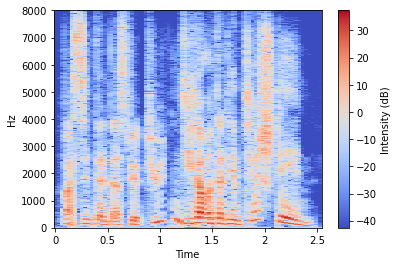

In [5]:
#get the short-term fourier transform
fourierplt = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
#convert it from raw values to dB (log)
findbplt = librosa.amplitude_to_db(abs(fourierplt))
#look at the spectrogram
librosa.display.specshow(findbplt, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar(label='Intensity (dB)')
plt.show()

In [6]:
#get the frequencies with the max power
def get_fpwr(clip):
    
    fourier = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
    #convert it from raw values to dB (log)
    findb = librosa.amplitude_to_db(abs(fourier))
    #0 is the frequency bins, 1 is the time stamp
    #frequency corresponding to each row
    f_bins = [i * f_res for i in range(fourier.shape[0])]
    
    #get the max energy value
    overallmaxdb = np.max(findb) 
    #find the row it's in
    overallindex = np.where(findb == overallmaxdb)
    #get the corresponding frequency for that row
    maxptf=f_bins[int(overallindex[0])] #frequency of maximum power at any point during the clip

    #sum up the energy for all time periods for each row
    rowsums = np.sum(fourier, axis=1)
    #get the max energy value
    rowmax = np.max(rowsums)
    #find the row it's in
    sumindex = np.where(rowsums == rowmax)
    #get the corresponding frequency for that row
    maxsumf=f_bins[int(sumindex[0])] #frequency of maximum power throughout the clip
    return(maxptf, maxsumf)

In [7]:
maxpwr = get_fpwr(audio_data)
print(maxpwr)

(570.3125, 375.0)


In [8]:
#get the spectral centroid
def get_spc(clip):
    centroidvect = librosa.feature.spectral_centroid(y=clip, sr=sample_rate)
    meancent = np.mean(centroidvect)
    return meancent

For the whole file:

In [9]:
filemeancent = get_spc(audio_data)
print(filemeancent)

1972.9028809924625


Split the waveplot into sections and get data for each

In [10]:
n = 6 #number of sections to split into +1
#the shortest filess are 1 second and we don't want clips shorter than 200 ms since that's what the human ear picks up
pps = np.round(pts/n) #points per section, with the last section getting the extras or shorted
cutoffs = [int(pps * i) for i in range(0, n-1)]
cutoffs.append(int(pts))

In [11]:
segsum = []
for i in range(0, n-1):
    shortclip = audio_data[cutoffs[i]:cutoffs[i+1]]
    maxdata = get_fpwr(shortclip)
    centdata= get_spc(shortclip)
    #print(maxdata[0], maxdata[1], centdata)
    segsum.append([maxdata[0], maxdata[1], centdata]) #f of peak pt energy, f of max total energy, centroid f

In [12]:
#raw info for each of the segments
print(segsum)

[[671.875, 656.25, 2434.193621326013], [492.1875, 437.5, 1896.6694980606032], [218.75, 250.0, 1912.7183008780378], [570.3125, 375.0, 1506.9271594537179], [398.4375, 281.25, 2031.8917216465552]]


Add comparisons to "normalize" the amplitudes to baseline

In [13]:
#Use the overall file mean centroid as the normalizer.
nmaxpwr = maxpwr/filemeancent
nseg = torch.tensor(segsum/filemeancent)



In [14]:
powervect = (maxpwr[0], maxpwr[1], nmaxpwr[0], nmaxpwr[1]) #max f at any point, f w max power, normalized max f at any point, normalized f w max power
segmat = torch.cat((torch.tensor(segsum), nseg), dim=1) #rows are each segment, 
#columns are f of peak pt energy, f of max total energy, centroid f, normalized f peak pt energy, normalized f max tot, normalized centroid

print(powervect, segmat)

(570.3125, 375.0, 0.2890727696201174, 0.19007524577761142) tensor([[6.7188e+02, 6.5625e+02, 2.4342e+03, 3.4055e-01, 3.3263e-01, 1.2338e+00],
        [4.9219e+02, 4.3750e+02, 1.8967e+03, 2.4947e-01, 2.2175e-01, 9.6136e-01],
        [2.1875e+02, 2.5000e+02, 1.9127e+03, 1.1088e-01, 1.2672e-01, 9.6949e-01],
        [5.7031e+02, 3.7500e+02, 1.5069e+03, 2.8907e-01, 1.9008e-01, 7.6381e-01],
        [3.9844e+02, 2.8125e+02, 2.0319e+03, 2.0195e-01, 1.4256e-01, 1.0299e+00]],
       dtype=torch.float64)


Find the gradient/differences

In [15]:
#to compare easily, make a new tensor that is the old one shifted. For sizing, need to make the original one line bigger as well
zerost = torch.zeros(1, 6)
lastt = torch.cat((segmat, zerost), dim=0)
nextt = torch.cat((zerost, segmat), dim=0)
diffs = nextt-lastt
grads = nextt/lastt #need to replace nans with 0s


In [16]:
#remove the last line since it doesn't have meaning and attach to the original summary to have something to return
tensoroutput = torch.cat((segmat, diffs[0:n-1], grads[0:n-1]), dim=1)
#columns: 1-3 segement f of peak pt energy, f of max total energy, centroid f 
#4-6: normalized 1-3. 7-9: raw difference between steps of first 3.
#10-12: raw difference between steps of 4-6. 
#13-15: % difference between steps of first 3.
#16-18: % difference between steps of 4-6.

print(tensoroutput.shape)

torch.Size([5, 18])


Let's plot the everything to make sure that it makes sense

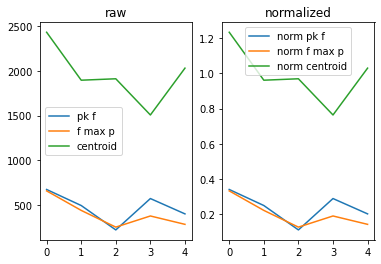

In [17]:
#stats and normalized stats
fpk = tensoroutput[:, 0]
fmax = tensoroutput[:, 1]
centf = tensoroutput[:, 2]
nfpk = tensoroutput[:, 3]
nfmax = tensoroutput[:, 4]
ncentf = tensoroutput[:, 5]

plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(fpk, label='pk f')
plt.plot(fmax, label='f max p')
plt.plot(centf, label='centroid')
plt.title('raw')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(nfpk, label='norm pk f')
plt.plot(nfmax, label='norm f max p')
plt.plot(ncentf, label='norm centroid')
plt.title('normalized')
plt.legend()

plt.show()

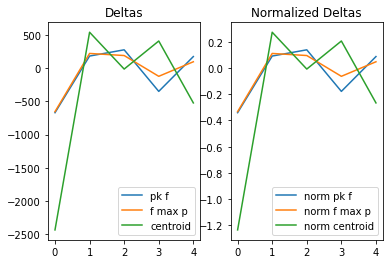

In [18]:
#changes and normalized changes
deltafpk = tensoroutput[:, 6]
deltafmax = tensoroutput[:, 7]
deltacentf = tensoroutput[:, 8]
deltanfpk = tensoroutput[:, 9]
deltanfmax = tensoroutput[:, 10]
deltancentf = tensoroutput[:, 11]


plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(deltafpk, label='pk f')
plt.plot(deltafmax, label='f max p')
plt.plot(deltacentf, label='centroid')
plt.title('Deltas')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(deltanfpk, label='norm pk f')
plt.plot(deltanfmax, label='norm f max p')
plt.plot(deltancentf, label='norm centroid')
plt.title('Normalized Deltas')
plt.legend()

plt.show()


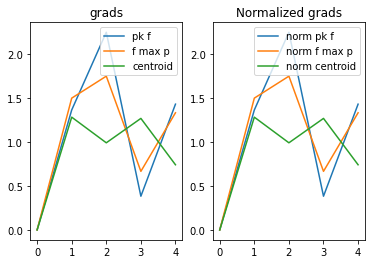

In [19]:
#changes and normalized changes
gradfpk = tensoroutput[:, 12]
gradfmax = tensoroutput[:, 13]
gradcentf = tensoroutput[:, 14]
gradnfpk = tensoroutput[:, 15]
gradnfmax = tensoroutput[:, 16]
gradncentf = tensoroutput[:, 17]


plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(gradfpk, label='pk f')
plt.plot(gradfmax, label='f max p')
plt.plot(gradcentf, label='centroid')
plt.title('grads')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gradnfpk, label='norm pk f')
plt.plot(gradnfmax, label='norm f max p')
plt.plot(gradncentf, label='norm centroid')
plt.title('Normalized grads')
plt.legend()

plt.show()


To compare with others, return the overall data as well as the tensor of segments

In [20]:
energypitch = (powervect, tensoroutput)
